# Time Series Classification and Esemble Methods
Questo esercizio riguarda l'utilizzo di 3 differenti approcci per la classificazione delle serie temporali, utilizzando il classificatore SBC (Sequential Boost Classifier). In particolare, questi 3 approcci devono essere eseguiti su un dataset binario e su un dataset multiclasse.
1. Il 1° task riguarda la Clustering Analysis -> dobbiamo allenare un I-SBC sull'intero dataset e poi calcolare le 3 distanze (breiman, zhi e ratio). Dopo dobbiamo applicare un algoritmo di clustering usando ogni distanza e valutare i risultati attraverso una metrica interna ed una metrica esterna -> questo lo dobbiamo fare su entrambi i dataset;
2. Il 2° task rigaurda la BE-SBC Conformal Prediction -> alleno un BE-SBC e creo un conformal predictor, andando a dividere i dati in 'train' e 'calibration' (fase di training set e fase di calibration set) e valuto la calibrazione e l'efficienza;
3. Il 3° task riguarda la Distance-based Classification -> alleno un I-SBC-NN classifier e per ogni classe, salvo il sample più vicino a 'x' (in base alla distanza scelta). Poi stimo la probabilità di ogni classe e uso il classificatore per costruire anche qui per costruire un conformal predictor -> valuto calibrazione ed efficienza.

NB!! Ogni SBC è una sequenza di weak-leaners: ciascuno guarda un punto della sequenza, applica un threshold t, una direzione d, e fa: hi(xi) = d * sgn(t - xi) dove sgn restituisce -1 oppure 1.


In [2]:
from importlib.util import find_spec
import subprocess, sys

# Installo i pacchetti: aeon (per serie temporali) e nonconformist (per conformal prediction)
required = ['aeon', 'nonconformist']
for pkg in required:
    if not find_spec(pkg):
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

In [3]:
# Carico e processo il dataset delle serie temporali
from aeon.datasets import load_classification
import numpy as np

# Caricamento del dataset
def load_dataset(dataset_type='binary'):
    if dataset_type == "binary":
        X, y = load_classification("ECG200")
    elif dataset_type == "multiclass":
        X, y = load_classification("SmoothSubspace")
    else:
        raise ValueError("Dataset type must be 'binary' or 'multiclass'")

    # Converto le etichette in interi
    y = y.astype(int)
    if dataset_type == "multiclass":
        y -= 1  # dato che nei dataset multiclasse le etichette partono da 1, così porto le classi a 0,1,2,...

    return X[:, 0, :], y

In [4]:
from sklearn.model_selection import train_test_split

# Suddividiamo i dati in 4 insiemi, necessari per la conformal prediction:
# train -> per allenare il classificatore;
# validation -> per ottimizzare i parametri;
# calibration -> per stimare la non conformità;
# test -> per la valutazione finale.

def split_data(dataset_type='binary', train_size=0.55, val_size=0.20, cal_size=0.15, test_size=0.10, random_state=42):  # controllo che le 4 parti sommate diano come risulato 1
    if not np.isclose(train_size + val_size + cal_size + test_size, 1.0):
        raise ValueError("La somma delle frazioni deve essere 1.")

    X, y = load_dataset(dataset_type)   # carico il dataset

    # Divido i dati in X_train e y_train, in modo da allenare il classificatore -> X_temp e y_temp hanno i dati non usati per il training e quindi li divido dopo
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, random_state=random_state)

    # Calcolo le proporzioni per le divisioni successive (questo lo faccio perchè suddivido i dati in più passaggi)
    remaining_ratio = val_size + cal_size + test_size
    test_ratio = test_size / remaining_ratio
    val_ratio = val_size / (val_size + cal_size)

    # Prendo una parte di X_temp come test set -> X_temp2 e y_temp2 verranno divisi dopo
    X_test, X_temp2, y_test, y_temp2 = train_test_split(X_temp, y_temp, train_size=test_ratio, random_state=random_state)

    # Divido i dati rimanenti in: X_val e y_val per il validation set; X_cal e y_cal per il calibration set
    X_val, X_cal, y_val, y_cal = train_test_split(X_temp2, y_temp2, train_size=val_ratio, random_state=random_state)

    return {    # ritorno gli insiemi
        "train": (X_train, y_train),
        "validation": (X_val, y_val),
        "calibration": (X_cal, y_cal),
        "test": (X_test, y_test)
    }

In [5]:
# uso il framework nonconformist per fare conformal prediction -> NB!! Richiede che i classificatori siano incapsulati in una classe ClassifierAdapter

from nonconformist.base import ClassifierAdapter

class MyClassifierAdapter(ClassifierAdapter):
    def __init__(self, model, method='majority', fit_params=None):
        super().__init__(model, fit_params)
        self.method = method  # imposta il tipo di voto

    def fit(self, x, y):
        self.model.fit(x, y)

    def predict(self, x):
        return self.model.predict_proba(x, method=self.method)

A questo punto, implementiamo e testiamo il SBC su un dataset binario di serie temporali. In particolare, attraverso la classe SBC andiamo ad implementare un classificatore debole sequenziale. Ogni h_i è un weak learner sul tempo 'i' e l'output finale è il segno di una combinazione pesante delle decisioni.

In [6]:
import numpy as np
from sklearn.utils import resample

# Definisco la classe SBC per la classificazione delle serie temporali bianrie
class SBC:
    def __init__(self, n_weak_learners=None):
        self.n_weak_learners = n_weak_learners  # numero di weak learners das usare e ogni weak learners è composta da:
        self.alpha = [] # un peso
        self.threshold = []
        self.direction = []

    def _init_structures(self, n):  # inizializzo ad 'n' i componenti di weak learner
        self.alpha = np.zeros(n)
        self.threshold = np.zeros(n)
        self.direction = np.ones(n)

    def _sign(self, x):  # implemento la funzione sgn(x)
        return np.where(x >= 0, 1, -1)

    def custom_sign(self, x):
        return np.where(x >= 0, 1, -1)

    def fit(self, X, y, validation_set=None, target_acc=0.95):  # alleno il modello -> se si supera il 95% su validation allora si blocca il training
        n_features = X.shape[1]
        self.n_weak_learners = self.n_weak_learners or n_features
        self._init_structures(self.n_weak_learners)

        n_samples = X.shape[0]
        weights = np.full(n_samples, 1 / n_samples)

        history = {'train': [], 'val': []}

        for i in range(self.n_weak_learners):   # l'idea è di trovare il miglior weak learner (quello con errore pesato minimo) e salvo threshold, direction e alpha. Poi calcolo le predizioni e aggiorna i pesi
            threshold_i, direction_i, alpha_i = self._best_learner(X[:, i], y, weights)
            self.threshold[i] = threshold_i
            self.direction[i] = direction_i
            self.alpha[i] = alpha_i
            preds = self._sign(threshold_i - X[:, i]) * direction_i
            weights = self._update_weights(weights, y, preds)
            history['train'].append(self.evaluate(X, y))
            if validation_set:
                val_score = self.evaluate(*validation_set)
                history['val'].append(val_score)
                if val_score >= target_acc:
                    break

        return history

    def _best_learner(self, Xi, y, weights):    # per trovare il miglior weak learner
        best_error = np.inf
        best_th, best_dir = None, None

        for th in np.unique(Xi):
            for d in [-1, 1]:
                preds = self._sign(th - Xi) * d
                err = np.sum(weights[preds != y]) / np.sum(weights)
                if err < best_error:
                    best_error = err
                    best_th, best_dir = th, d

        alpha = 0.5 * np.log((1 - best_error) / max(best_error, 1e-10))
        return best_th, best_dir, alpha

    def _update_weights(self, weights, y, preds):   # aggiorna i pesi
        incorrect = preds != y
        err = np.sum(weights[incorrect])
        err = max(err, 1e-10)
        alpha = 0.5 * np.log((1 - err) / err)
        weights *= np.exp(-alpha * y * preds)
        return weights / np.sum(weights)

    def predict(self, X, truncate=None):    # predizione
        limit = truncate or self.n_weak_learners
        h = self._sign(self.threshold[:limit] - X[:, :limit]) * self.direction[:limit]
        return self._sign(np.dot(h, self.alpha[:limit]))

    def predict_proba(self, X, truncate=None):  # restituisce la probabilità normalizzata (un valore tra 0 e 1)
        limit = truncate or self.n_weak_learners
        h = self._sign(self.threshold[:limit] - X[:, :limit]) * self.direction[:limit]
        positive_weight = np.sum(self.alpha[:limit] * (h == 1), axis=1)
        return positive_weight / np.sum(self.alpha[:limit])

    def evaluate(self, X, y):   # restituisce l'accuratezza sul dataset
        return np.mean(self.predict(X) == y)

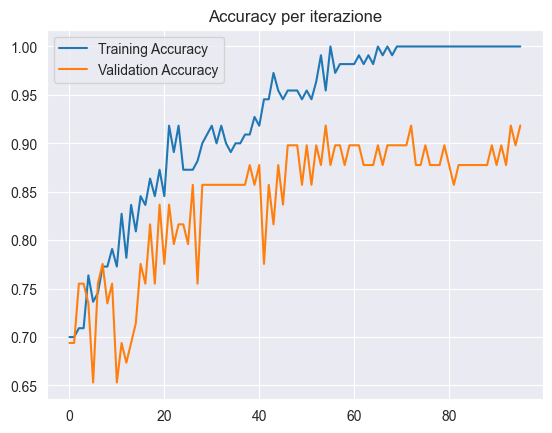

Accuracy finale: 0.789


In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Carico dataset binario e suddivido i dati nelle varie parti (train, validation, test e calibration)
data = split_data('binary', val_size=0.25, cal_size=0.01, test_size=0.19)
X_train, y_train = data['train']
X_val, y_val = data['validation']
X_test, y_test = data['test']

# Alleno SBC, creando un oggetto SBC e ad ogni ierazione, aggiungo un weak learner
sbc = SBC()
errors = sbc.fit(X_train, y_train, validation_set=(X_val, y_val))

# Plot andamento dell'accuracy
plt.plot(errors['train'], label='Training Accuracy')
if errors['val']:
    plt.plot(errors['val'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy per iterazione")
plt.show()

y_pred = sbc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy finale: {acc:.3f}")    # stampo il valore dell'accuracy

In [8]:
# Task 2 -> Adesso definiamo una classe BESBC (ensemble supervisionato di più classificatori SBC)
import numpy as np
from sklearn.utils import resample

class BESBC:
    def __init__(self, n_estimators=12, **sbc_params):  # n_estimators = numero di SBC da creare
        self.n_estimators = n_estimators
        self.sbc_params = sbc_params
        self.estimators = []  # Lista di modelli SBC
        self.validation_accuracies = []
        self.validation_fnrs = []  # False negative rate -> da memorizzare insieme all'accuracy
        self.unique_classes = []

    def fit(self, X, y, validation_set=None):   # allena l'ensemble
        self.unique_classes = np.unique(y)

        # Per ogni classificatore: estrae un bootstrap sample; sceglie una classe a caso e converte 'y' in etichette binarie
        for _ in range(self.n_estimators):
            # Campionamento bootstrap
            X_boot, y_boot = resample(X, y)

            # Scelta random di una classe
            selected_class = np.random.choice(self.unique_classes)
            y_binary = np.where(y_boot == selected_class, 1, -1)

            sbc = SBC(**self.sbc_params)
            sbc.class_label = selected_class
            sbc.fit(X_boot, y_binary)

            if validation_set:
                X_val, y_val = validation_set
                y_val_bin = np.where(y_val == selected_class, 1, -1)
                preds = sbc.predict(X_val)
                acc = np.mean(preds == y_val_bin)
                fnr = np.mean((preds == -1) & (y_val_bin == 1))
                self.validation_accuracies.append(acc)
                self.validation_fnrs.append(fnr)

            self.estimators.append(sbc) # aggiungo sbc all'ensemble

        return self.validation_accuracies

    def predict_proba(self, X, method='majority'):  # calcolo la probabilità sulle classi usando il metodo di voto che si ha scelto
        raw_votes = self._predict_raw_votes(X, method=method)
        row_sums = np.sum(raw_votes, axis=1, keepdims=True)
        # Per evitare divisione per zero
        row_sums[row_sums == 0] = 1
        return raw_votes / row_sums

    def _predict_raw_votes(self, X, method='majority'):     # smisto in base al tipo di voto
        if method == 'majority':
            return self._majority_voting(X)
        elif method == 'weighted':
            return self._weighted_voting(X)
        else:
            return self._track_record_voting(X)

    def _majority_voting(self, X):  # conto il numero di SBC che danno predizione 1 (quindi che appartengono alla classe assegnata) e sommo le predizioni
        scores = np.zeros((len(X), len(self.unique_classes)))
        for est in self.estimators:
            pred = est.predict(X) == 1
            scores[:, est.class_label] += pred
        return scores

    def _weighted_voting(self, X):  # ogni SBC viene pesato in base alla sua accuracy
        scores = np.zeros((len(X), len(self.unique_classes)))
        for est, acc in zip(self.estimators, self.validation_accuracies):
            pred = est.predict(X) == 1
            scores[:, est.class_label] += pred * acc
        return scores

    def _track_record_voting(self, X):  # se la predizione è 1, allora uso l'accuracy come peso; se la predizione è -1, allora uso il false negative rate
        scores = np.zeros((len(X), len(self.unique_classes)))
        for est, acc, fnr in zip(self.estimators, self.validation_accuracies, self.validation_fnrs):
            preds = est.predict(X)
            weights = np.where(preds == 1, acc, fnr)
            scores[:, est.class_label] += weights
        return scores

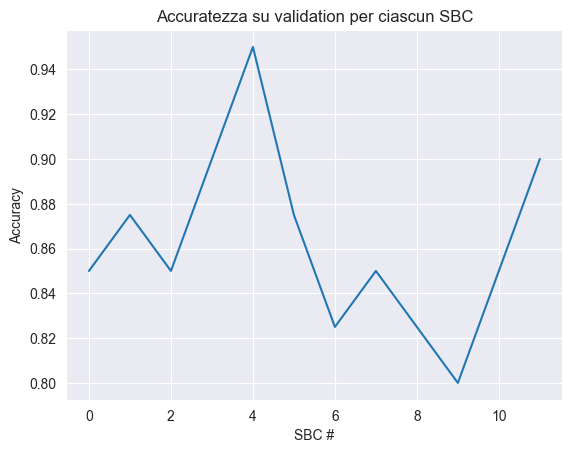

In [9]:
# Alleno e valuto l'ensemble BESBC su un dataset binario -> visualizzo l'accuracy per ogni classificatore SBC che compone BESBC

# carico il dataset e prendo solo i dati per il training e la validazione
dataset = split_data('binary')
X_train, y_train = dataset['train']
X_val, y_val = dataset['validation']

# Modifico le label -> trasformo -1 in 0 (1 rimane 1)
y_train = np.where(y_train == 1, 1, 0)
y_val = np.where(y_val == 1, 1, 0)

# Alleno l'ensemble -> ritorno l'array 'val_accs' con l'accuracy di ogni SBC
besbc = BESBC()
val_accs = besbc.fit(X_train, y_train, validation_set=(X_val, y_val))

# Plot per vedere l'accuratezza -> ho visto che l'accuracy è sempre sopra l'80% e ho trovato che è un buon livello di accuracy
import matplotlib.pyplot as plt
plt.plot(val_accs)
plt.title("Accuratezza su validation per ciascun SBC")
plt.xlabel("SBC #")
plt.ylabel("Accuracy")
plt.show()

Accuracy: 0.800


<Axes: >

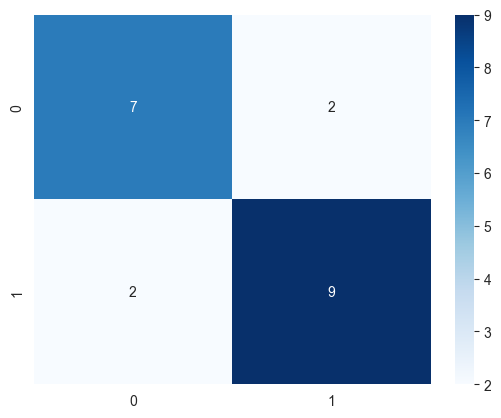

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

X_test, y_test = dataset['test']
y_test = np.where(y_test == 1, 1, 0)    # modifico anche in questo caso le label

# Predizione delle probabilità
probs = besbc.predict_proba(X_test)
y_pred = np.argmax(probs, axis=1)

# Confronto le classi ppredette (y_pred) con quelle reali (y_test) e calcolo l'accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")

# Calcolo la confusion matrix -> così vedo quante volte ho predetto ogni classe correttamente/in modo sbagliato
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # ottengo che: la classe 0 è stata predetta correttamente 6 volte (vero negativo); la classe 0 è stata predetta come 1 per 3 volte (falso positivo); la classe 1 è stata predetta come 0 per 2 volte (falso negativo); la classe 1 è stata predetta correttamente per 9 volte (vero positivo)

In [12]:
# Adesso devo creare il conformal predictor e calcolare la coverage e l'efficiency
from nonconformist.cp import IcpClassifier
from nonconformist.nc import ClassifierNc

model = MyClassifierAdapter(besbc, method='weighted')  # incapsulo BESBc nel formato richiesto da nonconformist

# creo effettivamente il conformal predictor
nc = ClassifierNc(model)
icp = IcpClassifier(nc)

# calibro il conformal predictor appena creato -> carica il calibration set; modifica le label e salva i punteggi di non conformità
X_cal, y_cal = dataset['calibration']
y_cal = np.where(y_cal == 1, 1, 0)
icp.calibrate(X_cal, y_cal)

# faccio le predizioni sul test set
X_test, y_test = dataset['test']
y_test = np.where(y_test == 1, 1, 0)
prediction_sets = icp.predict(X_test, significance=0.1) # livello di confidenza del 90%

# Calcolo copertura ed efficienza
coverage = np.mean([pred[y] for pred, y in zip(prediction_sets, y_test)])
print(f"Copertura (coverage): {coverage:.3f}")
efficiency = np.mean([np.sum(pred) for pred in prediction_sets])
print(f"Efficienza : {efficiency:.3f}")

Copertura (coverage): 0.800
Efficienza : 1.000


Classificazione su un dataset multiclasse con BESBC, con una valutazione tramite:
1. 3 metodi di voto (majority, weighted, track_record);
2. Accuracy e confusion matrix;
3. Conformal prediction su BESBC.
Per riuscire a fare ciò, carichiamo un dataset multiclasse; alleno un ensemble BE-SBC; valuta il modello con i 3 metodi di voto; costruisco un conformal predictor nonconformist sopra BESBC ed infine calibro con un set di calibrazione e testo.

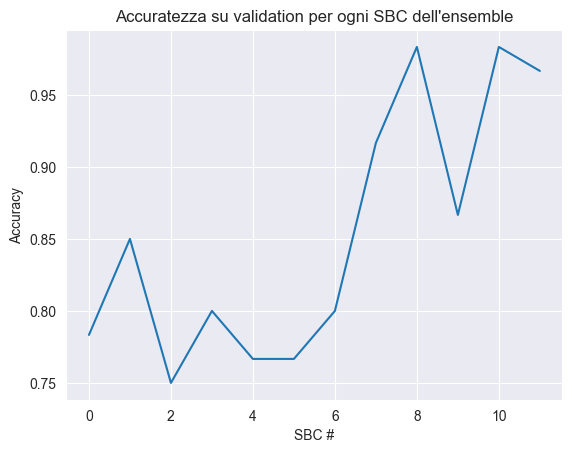

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Carico il dataset multiclasse -> NB!! le label sono già convertite
dataset = split_data('multiclass')
X_train, y_train = dataset['train'] # estraggo solamente i dati per il training e la validazione
X_val, y_val = dataset['validation']

# Inizializzo ed alleno l’ensemble BESBC
besbc = BESBC(n_estimators=12)
val_acc = besbc.fit(X_train, y_train, validation_set=(X_val, y_val))    # salvo le accuracy

# Visualizzo l’accuracy
plt.plot(val_acc)
plt.title("Accuratezza su validation per ogni SBC dell'ensemble")
plt.xlabel("SBC #")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

[majority] Accuracy: 0.967
[weighted] Accuracy: 1.000
[track_record] Accuracy: 0.967


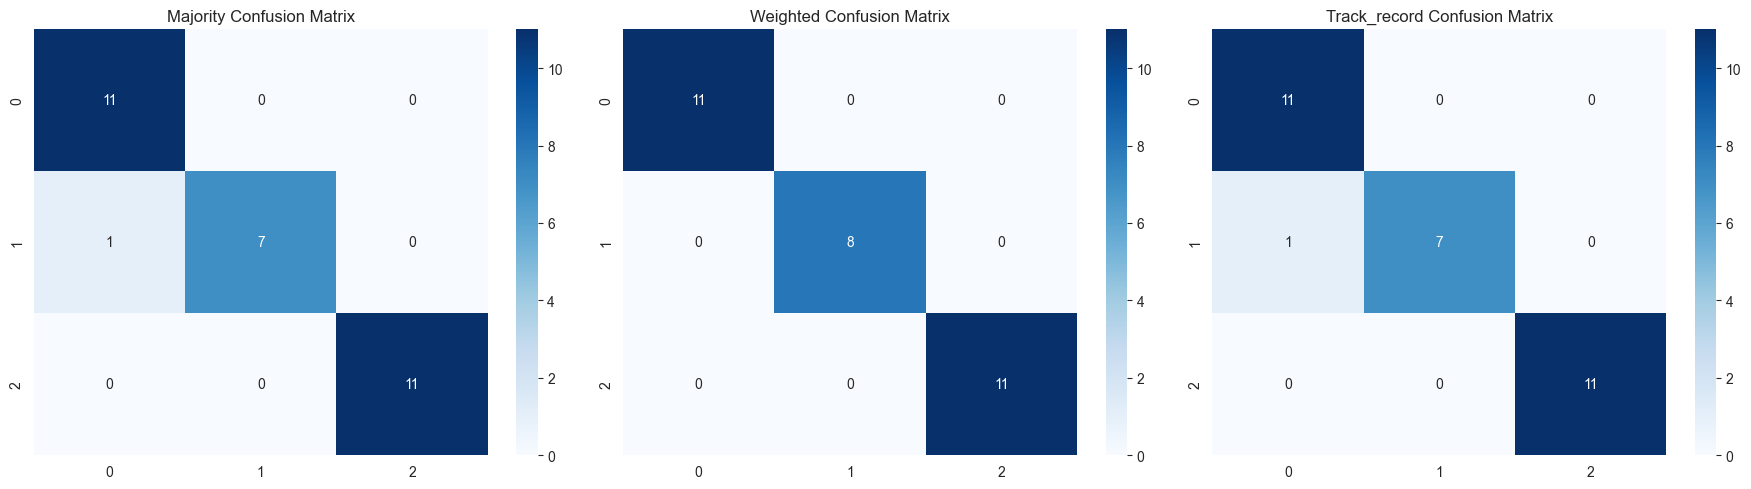

In [14]:
# Valuto BESBC usando le 3 strategie di voto e vedo la confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

X_test, y_test = dataset['test']    # carico il test set
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) # mi serve per mostrare le 3 confusion matrix

for ax, method in zip(axes, ['majority', 'weighted', 'track_record']):  # ciclo sui 3 metodi di voto
    proba = besbc.predict_proba(X_test, method=method)  # calcolo la probabilità per ogni classe
    y_pred = np.argmax(proba, axis=1)   # predizione finale -> scelgo la classe con la probabilità massima
    acc = accuracy_score(y_test, y_pred)    # calcolo l'accuracy
    print(f"[{method}] Accuracy: {acc:.3f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"{method.capitalize()} Confusion Matrix")

plt.tight_layout()
plt.show()

In [16]:
# Eseguo la conformal prediction sul dataset multiclasse con l'ensemble BESBC
from nonconformist.cp import IcpClassifier
from nonconformist.nc import ClassifierNc

# Adatto il BESBC per nonconformist e creo il conformal predictor
model = MyClassifierAdapter(besbc, method='majority')
nc = ClassifierNc(model)
icp = IcpClassifier(nc)

X_cal, y_cal = dataset['calibration']
icp.calibrate(X_cal, y_cal)

# Predizione sui dati di test
X_test, y_test = dataset['test']
prediction_sets = icp.predict(X_test, significance=0.05)
prediction_sets # ritorno i prediction set ottenuti

# Calcolo coverage ed efficiency
coverage = np.mean([pred[y] for pred, y in zip(prediction_sets, y_test)])
print(f"Coverage: {coverage:.3f}")
efficiency = np.mean([np.sum(pred) for pred in prediction_sets])
print(f"Efficienza: {efficiency:.3f}")


Coverage: 1.000
Efficienza: 2.300


A questo punto, vogliamo costruire un classificatore supervisionato basato su distanze tra serie temporali, utilizzando un ensemble non supervisionato I-SBC. Poi lo utilizziamo per un conformal predictor supervisionato. Capiamo, allora, che dobbiamo:
1. Costruire l'ensemble I-SBC -> uso la classe ISBC per creare 'n' modelli SBC e ogni SBC viene allenato su un campione casuale del dataset;
2. Definire le distanze -> usiamo 3 distanze diverse: breiman; zhu e ratio;
3. Costruiamo il classificatore I-SBC-NN;
4. Uso I-SBC-NN per il conformal predictor;
5. Calcolo la coverage e l'efficiency.

In [17]:
import numpy as np
from sklearn.utils import resample
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

class ISBC: # creo un ensemble non supervisionato SBC e lo utilizzo per definire le distante tra le sequenze temporali (x1; x2)
    def __init__(self, n_estimators=10, **sbc_params):  # n_estimators = numero di modelli SBC da creare
        self.n_estimators = n_estimators
        self.sbc_params = sbc_params
        self.estimators = []    # lista per contenere tutti gli SBC

    def fit(self, X):   # allena i modelli SBC su un sotto-insieme casuale e con label casuali
        self.estimators = []
        for _ in range(self.n_estimators):  # ciclo per il numero di modelli di SBC
            X_sample = resample(X)
            y_random = np.random.choice([-1, 1], size=len(X_sample))
            sbc = SBC(**self.sbc_params)
            sbc.fit(X_sample, y_random)
            self.estimators.append(sbc)
        return self

    def breiman_distance(self, x1, x2): # per ogni modelli SBC genero 2 vettori di predizioni su x1 e x2 -> se le predizioni sono uguali, allora aggiungo +1 a 'identical' -> se le sequenze si comportano uguali, allora la distanza è 0, altrimenti è 1
        identical = 0
        for est in self.estimators:
            pred1 = [est.custom_sign(t - x) * d for t, d, x in zip(est.threshold, est.direction, x1)]
            pred2 = [est.custom_sign(t - x) * d for t, d, x in zip(est.threshold, est.direction, x2)]
            if pred1 == pred2:
                identical += 1
        return 1 - (identical / self.n_estimators)

    def zhu_distance(self, x1, x2): # per ogni modelli SBC, confronta le predizioni sulle serie temporali e conta quanti step sono uguali le due serie -> ovvero calcola quanto a lungo x1 e x2 si comportano allo stesso modo
        total_prefix, total_len = 0, 0
        for est in self.estimators:
            match = 0
            for t, d, a, b in zip(est.threshold, est.direction, x1, x2):
                if est.custom_sign(t - a) * d != est.custom_sign(t - b) * d:
                    break
                match += 1
            total_prefix += match
            total_len += len(est.threshold)
        return 1 - (total_prefix / total_len)

    def ratio_distance(self, x1, x2):   # calcola la percentuale di decisioni uguali
        matches, total = 0, 0
        for est in self.estimators:
            for t, d, a, b in zip(est.threshold, est.direction, x1, x2):
                p1 = est.custom_sign(t - a) * d
                p2 = est.custom_sign(t - b) * d
                matches += int(p1 == p2)
                total += 1
        return 1 - (matches / total)

Attraverso la funzione 'evaluate_clustering' vado a valutare la qualità del clustering ottenuto usando le 3 dimensioni definite nella classe ISBC -> vado quindi a calcolare le matrici di distanza tra tutte le coppie di sequenze; uso KMeans per fare il clustering e valuto quest'ultimo attraverso una metrica interna ed esterna (intra_inter ratio e Geometric index).
Calcolo la intra_inter ratio perchè valuta la qualità del clustering solamente attraverso la distanza tra i punti e i cluster trovati da KMeans -> di conseguenza trovo GI = intra-classe / inter-classe

In [18]:
def evaluate_clustering(X, y_true=None, n_estimators=10, n_clusters=3):
    n = len(X)
    isbc = ISBC(n_estimators=n_estimators)  # definisco ISBC con n_estimators modelli SBC
    isbc.fit(X) # alleno ISBC sul dataset X

    # Inizializzo le matrici di distanza
    distance_matrices = {
        "breiman": np.zeros((n, n)),
        "zhu":     np.zeros((n, n)),
        "ratio":   np.zeros((n, n))
    }

    # Calcolo le distanze -> NB!! Per efficienza calcolo le distanze solo per il triangolo superiore e poi rendo la matrice simmetrica
    for i in range(n):
        for j in range(i+1, n):
            distance_matrices["breiman"][i, j] = isbc.breiman_distance(X[i], X[j])
            distance_matrices["zhu"][i, j]     = isbc.zhu_distance(X[i], X[j])
            distance_matrices["ratio"][i, j]   = isbc.ratio_distance(X[i], X[j])
    for mat in distance_matrices.values():
        mat += mat.T  # rendo le matrici simmetriche

    results = {}
    for name, dist in distance_matrices.items():
        kmeans = KMeans(n_clusters=n_clusters, random_state=42) # applico KMeans direttamente sulla matrice
        labels = kmeans.fit_predict(dist)

        # Calcolo la metrica interna ed esterna
        intra, inter = 0, 0
        for k in range(n_clusters):
            cluster = labels == k
            if np.sum(cluster) > 1:
                intra += np.sum(dist[cluster][:, cluster]) / (2 * np.sum(cluster))
        for i in range(n_clusters):
            for j in range(i+1, n_clusters):
                mask_i = labels == i
                mask_j = labels == j
                if np.any(mask_i) and np.any(mask_j):
                    inter += np.mean(dist[mask_i][:, mask_j])

        intra_inter_ratio = intra / (inter + 1e-10) # più basso è il valore, meglio è per il clustering

        if y_true is not None:
            classes = np.unique(y_true)
            intra_c, inter_c = 0, 0
            for c in classes:
                mask = y_true == c
                if np.sum(mask) > 1:
                    intra_c += np.sum(dist[mask][:, mask]) / (2 * np.sum(mask))
            for i in range(len(classes)):
                for j in range(i+1, len(classes)):
                    m1 = y_true == classes[i]
                    m2 = y_true == classes[j]
                    if np.any(m1) and np.any(m2):
                        inter_c += np.mean(dist[m1][:, m2])
            gi = intra_c / (inter_c + 1e-10)    # anche in questo caso, meglio che il valore sia basso
        else:
            gi = None

        results[name] = {   # salvo i risultati
            "intra_inter_ratio": intra_inter_ratio,
            "geometric_index": gi
        }

        # Stampo i risultati
        print(f"[{name.upper()}] Intra/Inter Ratio = {intra_inter_ratio:.4f}", end="")
        if gi is not None:
            print(f" | Geometric Index = {gi:.4f}")
        else:
            print(" | Geometric Index = N/A (no labels)")

    return results, distance_matrices

[BREIMAN] Intra/Inter Ratio = 4.4739 | Geometric Index = 4.4826
[ZHU] Intra/Inter Ratio = 4.0685 | Geometric Index = 4.2899
[RATIO] Intra/Inter Ratio = 3.7091 | Geometric Index = 3.6886


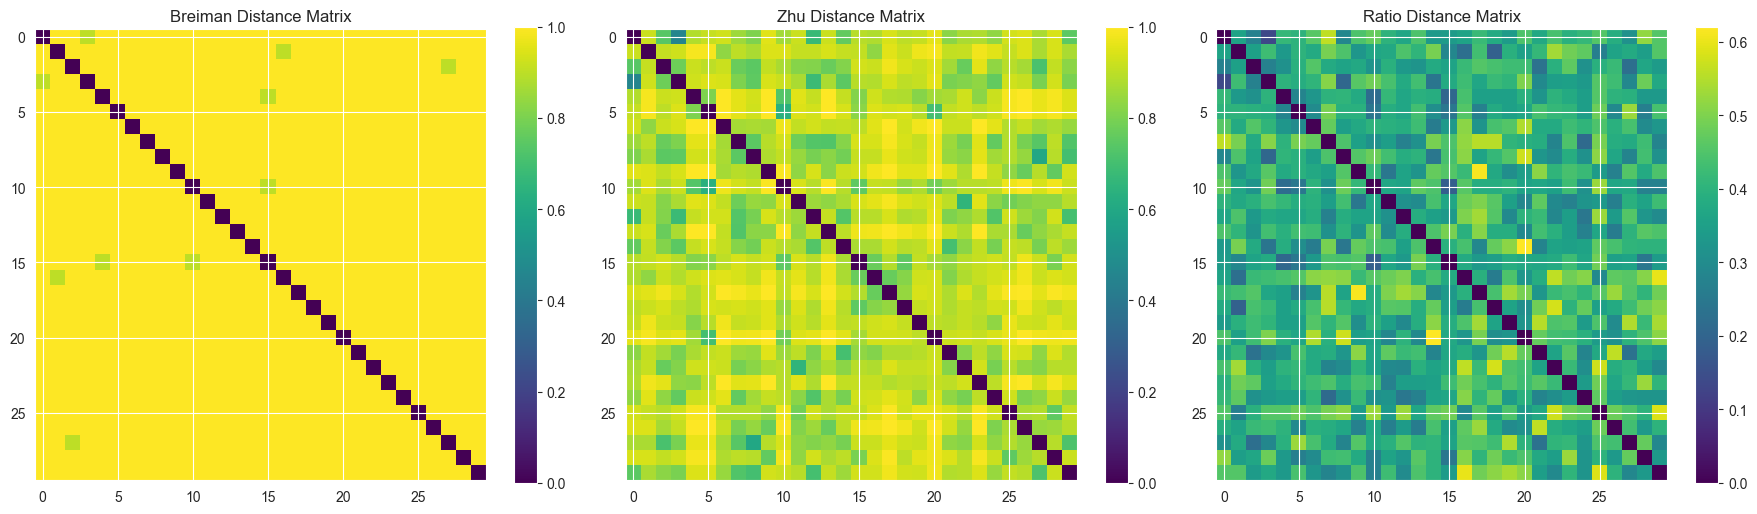

In [19]:
# Visualizzo le 3 matrici di distanza
def plot_distance_matrices(distance_matrices):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for ax, (name, mat) in zip(axes, distance_matrices.items()):
        im = ax.imshow(mat, cmap='viridis')
        ax.set_title(f"{name.capitalize()} Distance Matrix")
        plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

results, matrices = evaluate_clustering(X_test, y_true=y_test, n_estimators=10, n_clusters=3)
plot_distance_matrices(matrices)

Infine, faccio un'analisi del clustering non supervisionato sia sul dataset binario sia sul dataset multiclasse, utilizzando ISBC e le 3 distanze.

[BREIMAN] Intra/Inter Ratio = 96.0000 | Geometric Index = 96.0000
[ZHU] Intra/Inter Ratio = 94.9782 | Geometric Index = 95.5348
[RATIO] Intra/Inter Ratio = 64.8830 | Geometric Index = 78.5560
RISULTATI SU DATASET BINARIO:

 Breiman distance
 - Intra/Inter cluster ratio: 96.000
 - Geometric Index (GI):      96.000

 Zhu distance
 - Intra/Inter cluster ratio: 94.978
 - Geometric Index (GI):      95.535

 Ratio distance
 - Intra/Inter cluster ratio: 64.883
 - Geometric Index (GI):      78.556


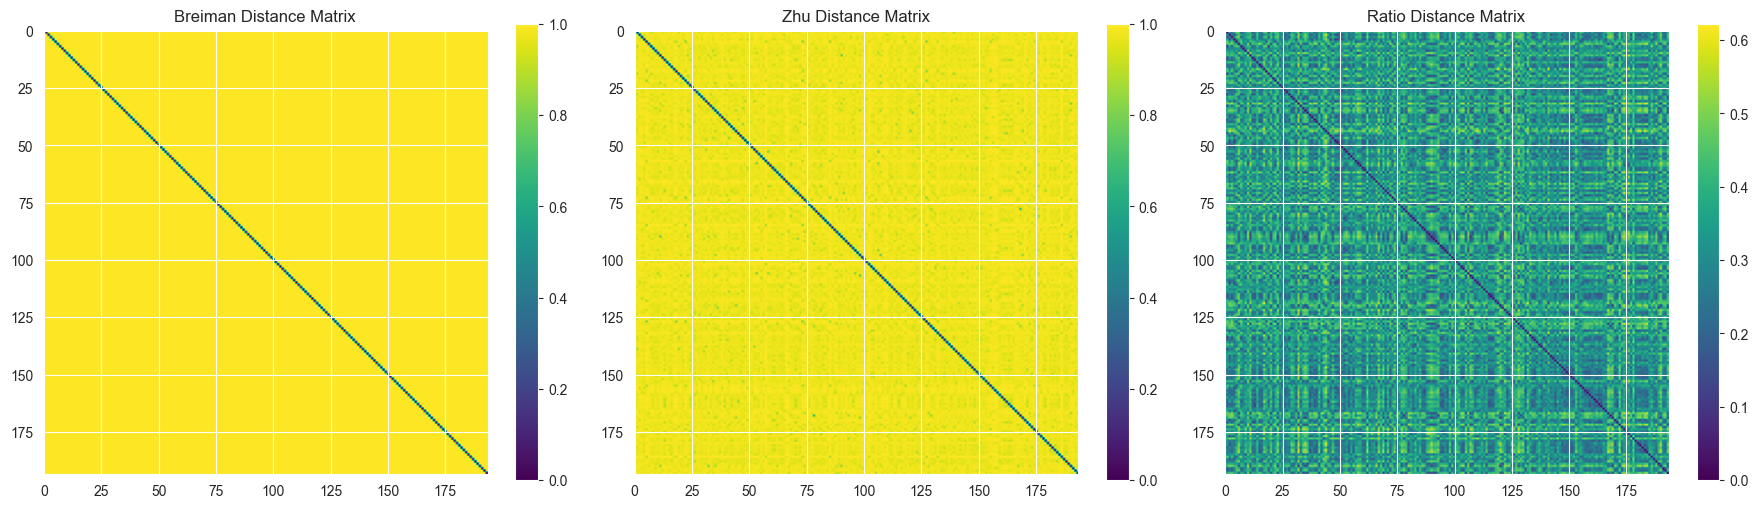

<Figure size 640x480 with 0 Axes>

In [20]:
# Dataset binario
from matplotlib import pyplot as plt

# Carico il dataset binario e utilizzo solo il training set (che è il 97% dei dati) per il clustering -> gli altri dati non servono (visto che il clustering è unsupervised)
X_bin, y_bin = split_data('binary', train_size=0.97, val_size=0.01, cal_size=0.01, test_size=0.01)['train']
y_bin = np.where(y_bin == 1, 1, 0)

results_bin, matrices_bin = evaluate_clustering(X_bin, y_true=y_bin, n_clusters=2)  # definisco un ISBC e calcolo le 3 matrici di distanza e la metrica interna ed esterna

# Stampo i risultati
print("RISULTATI SU DATASET BINARIO:")
for method, metrics in results_bin.items():
    print(f"\n {method.capitalize()} distance")
    print(f" - Intra/Inter cluster ratio: {metrics['intra_inter_ratio']:.3f}")
    if metrics.get('geometric_index') is not None:
        print(f" - Geometric Index (GI):      {metrics['geometric_index']:.3f}")
    else:
        print(" - Geometric Index (GI):      N/A")

# Visualizzo le matrici di distanza
plot_distance_matrices(matrices_bin)
plt.suptitle("Binary dataset - Distanze ISBC", fontsize=14)
plt.show()

[BREIMAN] Intra/Inter Ratio = 47.8256 | Geometric Index = 47.8274
[ZHU] Intra/Inter Ratio = 43.7808 | Geometric Index = 45.7042
[RATIO] Intra/Inter Ratio = 38.2417 | Geometric Index = 38.0350
RISULTATI SU DATASET MULTICLASSE:

 Breiman distance
 - Intra/Inter cluster ratio: 47.826
 - Geometric Index (GI):      47.827

 Zhu distance
 - Intra/Inter cluster ratio: 43.781
 - Geometric Index (GI):      45.704

 Ratio distance
 - Intra/Inter cluster ratio: 38.242
 - Geometric Index (GI):      38.035


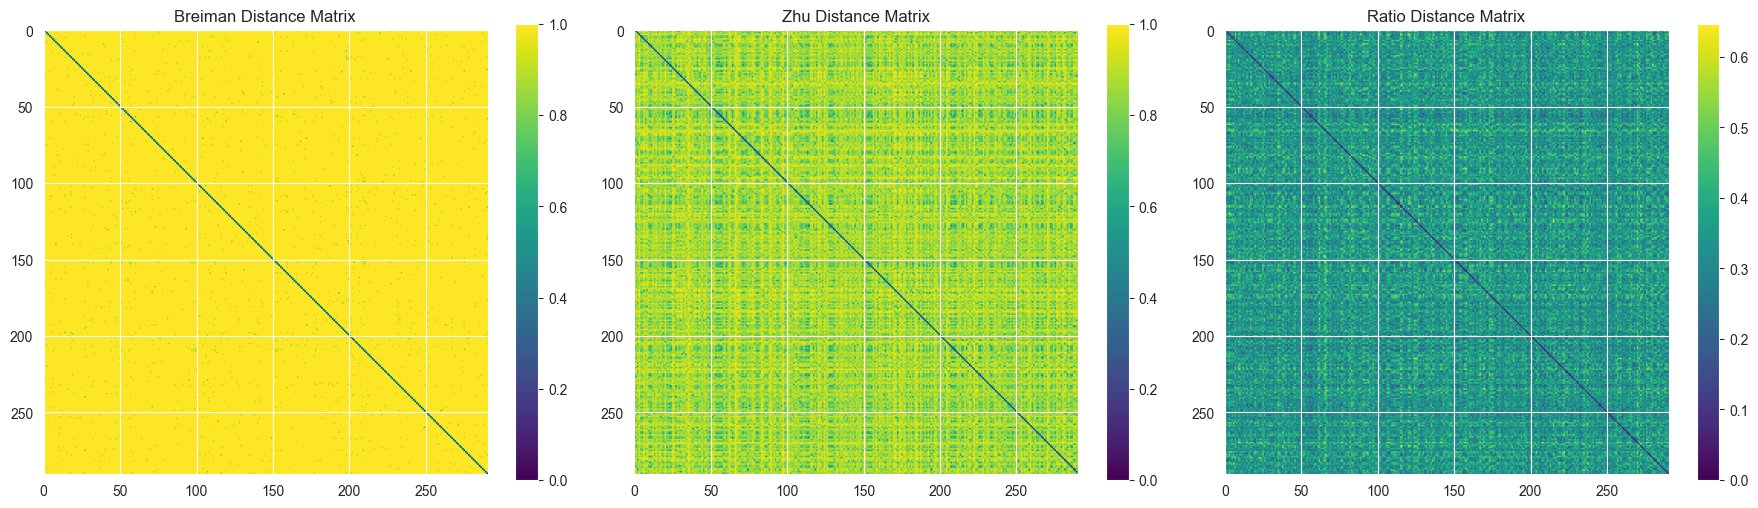

<Figure size 640x480 with 0 Axes>

In [21]:
# Dataset multiclasse -> stesso procedimento di prima con il dataset binario
X_multi, y_multi = split_data('multiclass', train_size=0.97, val_size=0.01, cal_size=0.01, test_size=0.01)['train']

n_classes = len(np.unique(y_multi))
results_multi, matrices_multi = evaluate_clustering(X_multi, y_true=y_multi, n_clusters=n_classes)

# Stampo risultati
print("RISULTATI SU DATASET MULTICLASSE:")
for method, metrics in results_multi.items():
    print(f"\n {method.capitalize()} distance")
    print(f" - Intra/Inter cluster ratio: {metrics['intra_inter_ratio']:.3f}")
    if metrics.get('geometric_index') is not None:
        print(f" - Geometric Index (GI):      {metrics['geometric_index']:.3f}")
    else:
        print(" - Geometric Index (GI):      N/A")

plot_distance_matrices(matrices_multi)
plt.suptitle("Multiclass dataset - Distanze ISBC", fontsize=14)
plt.show()

Terzo task -> definiamo un classificatore supervisionato basato su nearest neighbor per ogni classe, in cui la distanza tra le sequenze viene calcolata usando ISBC. Capiamo, allora, che dobbiamo:
1. Implementare il modello ISBC-NN, il quale utilizza ISBC per calcolare le distanze tra le sequenze temporali;
2. Allenare ISBC-NN su un dataset binario e multiclasse;
3. Creare un conformal predictor;
4. Calcolare la coverage e l'efficiency.

In [23]:
class ISBCNN:
    def __init__(self, n_estimators=10, n_weak_learners=None):
        self.n_estimators = n_estimators    # numero di modelli SBC da usare nell'ensemble ISBC
        self.n_weak_learners = n_weak_learners  # numero di weak learner per ogni SBC
        self.isbc = None    # oggetto ISBC
        self.X_train = None # per il training set
        self.y_train = None # per il training set
        self.classes_ = None # label

    def fit(self, X, y):    # per creare ISBC che alleno su X (con label random)
        # salvo X e Y come training set
        self.X_train = X
        self.y_train = y
        self.classes_ = np.unique(y)

        self.isbc = ISBC(n_estimators=self.n_estimators, n_weak_learners=self.n_weak_learners)
        self.isbc.fit(X)
        return self

    def _get_distance(self, x1, x2, distance_metric='ratio'):   # calcolo la distanza tra due sequenze X1 e X2 usando le 3 misure
        if distance_metric == 'breiman':
            return self.isbc.breiman_distance(x1, x2)
        elif distance_metric == 'zhu':
            return self.isbc.zhu_distance(x1, x2)
        else:
            return self.isbc.ratio_distance(x1, x2)

    def predict_proba(self, X, method='ratio', **kwargs):   # mi serve per il conformal prediction, in quanto quest'ultimo richiede che il classificatore restituisca una probabilità e non solo le etichette
        distance_metric = method
        probs = np.zeros((len(X), len(self.classes_)))

        for i, x in enumerate(X):
            for class_label in self.classes_:
                samples = self.X_train[self.y_train == class_label]
                if len(samples) > 0:
                    distances = [self._get_distance(x, s, distance_metric=distance_metric) for s in samples]
                    probs[i, class_label] = 1 - min(distances)  # più vicino = più probabile

        row_sums = np.sum(probs, axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1  # evita divisione per zero
        return probs / row_sums

Breiman Accuracy: 1.000
Zhu Accuracy: 1.000
Ratio Accuracy: 1.000


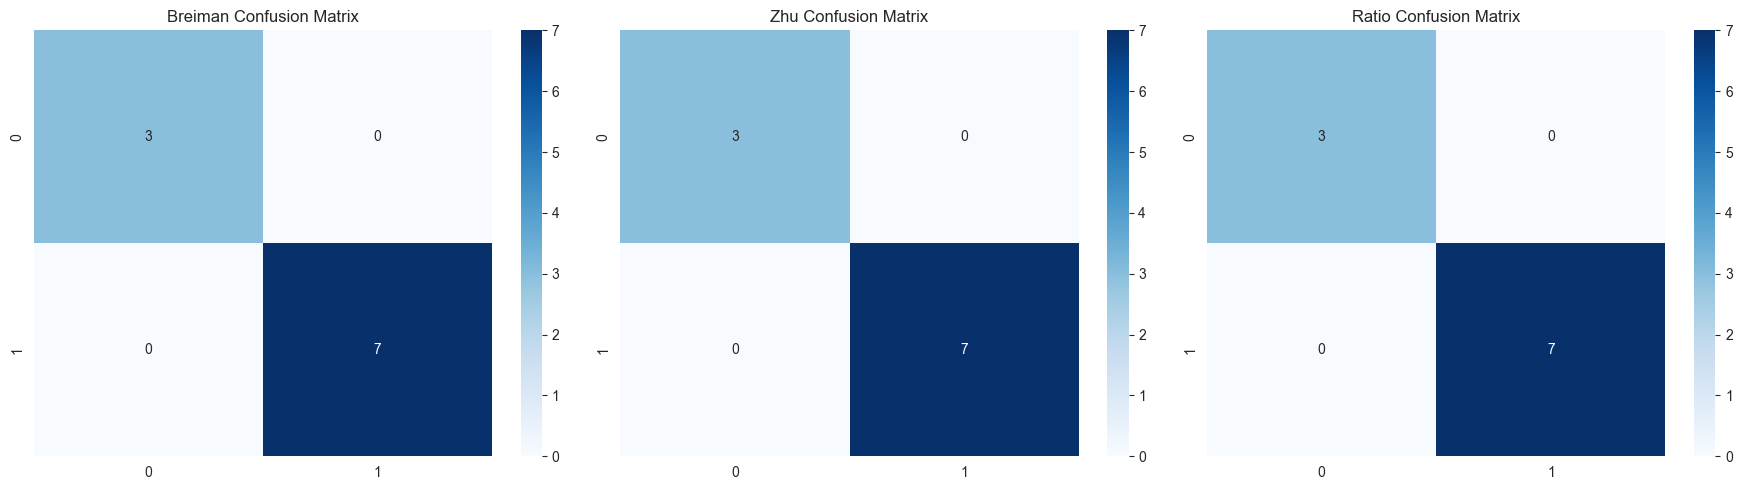

In [24]:
# Eseguo la valutazione supervisionata di ISBC-NN sul dataset binario usando le 3 dimensioni
dataset = split_data('binary', train_size=0.85, val_size=0.05, cal_size=0.05, test_size=0.05)   # carico il dataset e divido i dati

# Estraggo i dati che mi servono per il training e il testing del classificatore
X_train, y_train = dataset['train']
X_test, y_test = dataset['test']
X_cal, y_cal = dataset['calibration']

# Converto le label
y_train = np.where(y_train == 1, 1, 0)
y_test = np.where(y_test == 1, 1, 0)
y_cal = np.where(y_cal == 1, 1, 0)

# Alleno ISBCNN sul training set
isbc_nn = ISBCNN()
isbc_nn.fit(X_train, y_train)

# Valutazione con le 3 distanze
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, metric in zip(axes, ['breiman', 'zhu', 'ratio']):
    proba = isbc_nn.predict_proba(X_test, distance_metric=metric)   # calcolo le probabilità predette
    y_pred = np.argmax(proba, axis=1)

    # calcolo l'accuracy e la confusion matrix
    acc = accuracy_score(y_test, y_pred)
    print(f"{metric.capitalize()} Accuracy: {acc:.3f}")
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"{metric.capitalize()} Confusion Matrix")

plt.tight_layout()
plt.show()

In [26]:
# Applico la conformal prediction supervisionata a ISBC-NN
from nonconformist.cp import IcpClassifier
from nonconformist.nc import ClassifierNc

model = MyClassifierAdapter(isbc_nn, method='ratio')
nc = ClassifierNc(model)
icp = IcpClassifier(nc)

icp.calibrate(X_cal, y_cal)
prediction_sets = icp.predict(X_test, significance=0.05)
prediction_sets

# calcolo la coverage e l'efficiency
coverage = np.mean([pred[y] for pred, y in zip(prediction_sets, y_test)])
print(f" Coverage (confidenza reale): {coverage:.3f}")
efficiency = np.mean([np.sum(pred) for pred in prediction_sets])
print(f" Efficienza: {efficiency:.3f}")

 Coverage (confidenza reale): 1.000
 Efficienza: 1.600


Breiman Accuracy: 1.000
Zhu Accuracy: 1.000
Ratio Accuracy: 1.000


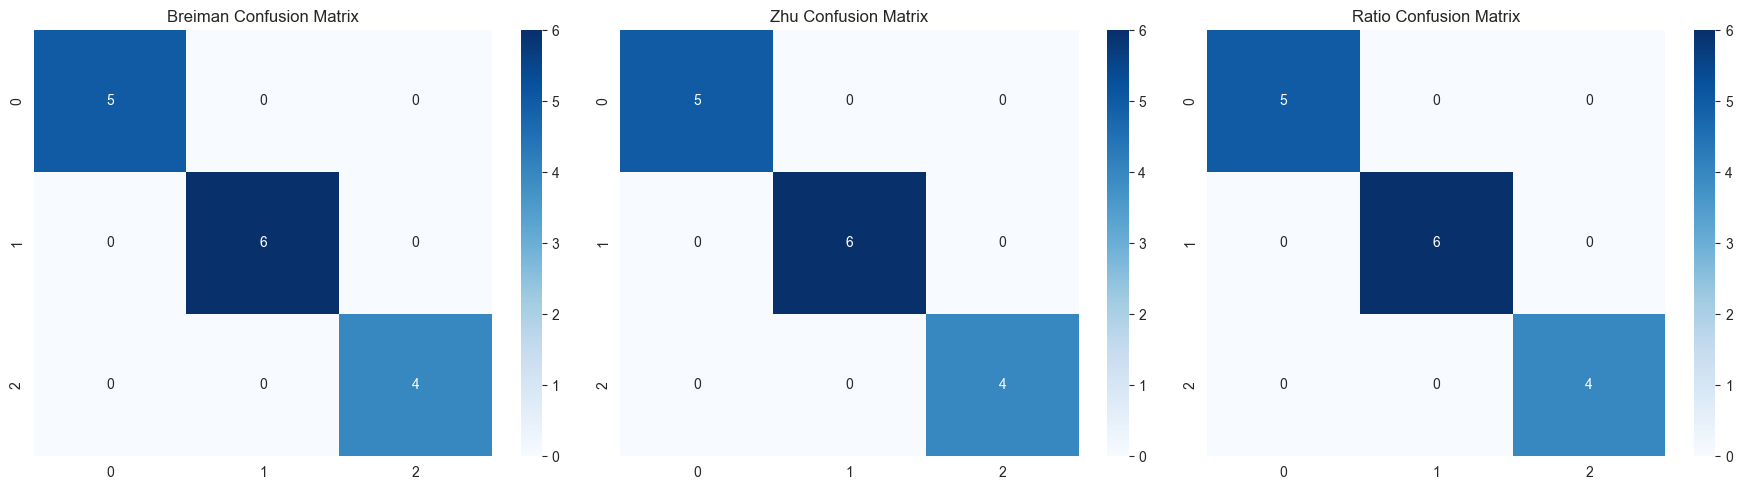

In [27]:
# Faccio la stessa cosa di prima ma sul dataset multiclasse
dataset = split_data('multiclass', train_size=0.85, val_size=0.05, cal_size=0.05, test_size=0.05)

X_train, y_train = dataset['train']
X_test, y_test = dataset['test']
X_cal, y_cal = dataset['calibration']

isbc_nn = ISBCNN()
isbc_nn.fit(X_train, y_train)

# Valutazione
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, metric in zip(axes, ['breiman', 'zhu', 'ratio']):
    proba = isbc_nn.predict_proba(X_test, distance_metric=metric)
    y_pred = np.argmax(proba, axis=1)

    acc = accuracy_score(y_test, y_pred)
    print(f"{metric.capitalize()} Accuracy: {acc:.3f}")

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"{metric.capitalize()} Confusion Matrix")

plt.tight_layout()
plt.show()

In [28]:
model = MyClassifierAdapter(isbc_nn, method='ratio')
nc = ClassifierNc(model)
icp = IcpClassifier(nc)

icp.calibrate(X_cal, y_cal)
prediction_sets = icp.predict(X_test, significance=0.05)
prediction_sets

# calcolo la coverage e l'efficiency
coverage = np.mean([pred[y] for pred, y in zip(prediction_sets, y_test)])
print(f" Coverage (confidenza reale): {coverage:.3f}")
efficiency = np.mean([np.sum(pred) for pred in prediction_sets])
print(f" Efficienza: {efficiency:.3f}")

 Coverage (confidenza reale): 1.000
 Efficienza: 1.333
